In [1]:
import tensorflow as tf
import os,shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow. keras.applications import InceptionResNetV2

In [2]:
data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
import os, shutil
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights='imagenet', input_tensor=Input(shape=(128,128,3)))


# 輸出層
x = model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


219070464/219055592 [==============================] - 5s 0us/step


In [5]:
#model.layers[0].trainable=False
checkpoint = ModelCheckpoint('InceptionResNetV2_checkpoint_v2.h5', verbose=1,
                          monitor='val_loss', save_best_only=True,
                          mode='min')
reduce_learning_rate= ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                           patience=5, mode='min', verbose=1,
                           min_learning_rate=1e-6)

estop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [6]:
num_classs=3
image_size=128
batch_size_training=20
batch_size_validation=20

train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.5,
                          fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
   "/content/drive/MyDrive/mask_ai/train" ,
   target_size=(image_size,image_size),
   batch_size=batch_size_training
   #class_mode="categorical"
)

valid_generator=valid_datagen.flow_from_directory(
   "/content/drive/MyDrive/mask_ai/valid" ,
   target_size=(image_size,image_size),
   batch_size=batch_size_validation
   #class_mode="categorical"
)

Found 2998 images belonging to 3 classes.
Found 1499 images belonging to 3 classes.


In [7]:
steps_per_epoch_train = len(train_generator)
steps_per_epoch_val= len(valid_generator)

In [8]:
history = model.fit(train_generator,
           epochs=20, verbose=1,
           steps_per_epoch= steps_per_epoch_train,
           validation_data=valid_generator,
           validation_steps=steps_per_epoch_val,
           callbacks=[checkpoint, estop, reduce_learning_rate])

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.8846
Epoch 00001: val_loss improved from inf to 0.55907, saving model to InceptionResNetV2_checkpoint_v2.h5
150/150 [==============================] - 1523s 10s/step - loss: 0.3041 - accuracy: 0.8846 - val_loss: 0.5591 - val_accuracy: 0.7525 - lr: 1.0000e-04
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9513
Epoch 00002: val_loss did not improve from 0.55907
150/150 [==============================] - 70s 467ms/step - loss: 0.1315 - accuracy: 0.9513 - val_loss: 9.9262 - val_accuracy: 0.8893 - lr: 1.0000e-04
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9600
Epoch 00003: val_loss did not improve from 0.55907
150/150 [==============================] - 70s 466ms/step - loss: 0.1092 - accuracy: 0.9600 - val_loss: 43.8713 - val_accuracy: 0.9713 - lr: 1.0000e-04
Epoch 4/20
150/150 [==============================] -

In [9]:
from keras.models import load_model
model.save('/content/drive/MyDrive/Colab Notebooks/ai_training_model_save')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/ai_training_model_save/assets


In [10]:
import os, shutil
from google.colab import drive
drive.mount('/content/drive/')
incep_saved = load_model('/content/drive/MyDrive/Colab Notebooks/ai_training_model_save')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


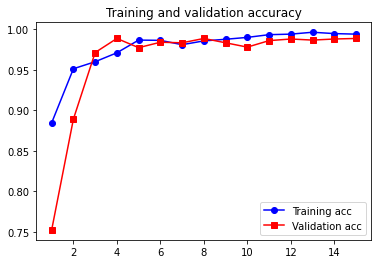

<Figure size 432x288 with 0 Axes>

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'rs-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.show()

In [12]:
test_gen=test_datagen.flow_from_directory(
   "/content/drive/MyDrive/mask_ai/test" ,
   target_size=(image_size,image_size),
   shuffle=False
)
steps_per_epoch_test= len(test_gen)

Found 1499 images belonging to 3 classes.


In [13]:
# -------------------------6.驗證模型準確度--------------------------
test_loss,test_acc = incep_saved.evaluate_generator(test_gen,steps_per_epoch_test,verbose=1)
print('test acc:', test_acc)
print('test loss:', test_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


47/47 [==============================] - 397s 9s/step - loss: 0.0093 - accuracy: 0.9967
test acc: 0.9966644644737244
test loss: 0.009291298687458038


In [14]:
predict = incep_saved.predict(test_gen).argmax(axis = 1)
true_classes = test_gen.classes
print('true classes=',true_classes)
print('predict classes=',predict)

class_labels = list(test_gen.class_indices.keys()) 
class_labels

true classes= [0 0 0 ... 2 2 2]
predict classes= [0 0 0 ... 2 2 2]


['incorrect', 'with_mask', 'without_mask']

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[499   0   0]
 [  3 496   1]
 [  1   0 499]]


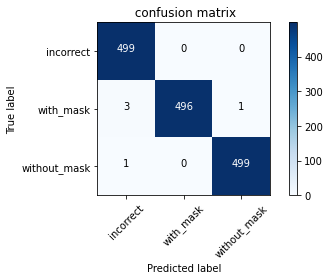

In [16]:
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

plt.figure()
cnf_matrix = confusion_matrix(true_classes, predict)
plot_confusion_matrix(cnf_matrix, classes=class_labels,normalize=False,
                    title=' confusion matrix')
plt.show()